Import Libraries


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import datetime, math
from datetime import date, timedelta
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras import losses, optimizers
from sklearn.impute import SimpleImputer
from keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
#Loading Data
ticker = "BARC.L"
data = yf.download(ticker, start="2004-01-01", end="2024-06-30")

[*********************100%%**********************]  1 of 1 completed


In [4]:
#Data Cleaning
data.reset_index(inplace=True)
data.dropna(inplace=True)

#Handling missing values in a more robust way
imputer = SimpleImputer(strategy='mean')
data['Close'] = imputer.fit_transform(data[['Close']])

#Splitting Data
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

#Shapes of Training and Testing Sets
data_train.shape[0]
data_test.shape[0]

#Scaling Data
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)
data_test_scale = scaler.transform(data_test)

#Creating Training Sequences:
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

x, y = np.array(x), np.array(y)


In [5]:
#Building the LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,input_shape = ((x.shape[1],1))))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(units = 100, activation = 'relu'))
lstm_model.add(Dropout(0.4))

lstm_model.add(Dense(units =1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [6]:
from tensorflow.keras import losses, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Fitting the model to the training data
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(x,y, epochs = 100, batch_size =32, verbose =1)




Epoch 1/100
127/127 [==============================] - 27s 174ms/step - loss: 0.0177
Epoch 2/100
127/127 [==============================] - 24s 186ms/step - loss: 0.0048
Epoch 3/100
127/127 [==============================] - 23s 183ms/step - loss: 0.0043
Epoch 4/100
127/127 [==============================] - 24s 188ms/step - loss: 0.0036
Epoch 5/100
127/127 [==============================] - 24s 186ms/step - loss: 0.0035
Epoch 6/100
127/127 [==============================] - 24s 187ms/step - loss: 0.0037
Epoch 7/100
127/127 [==============================] - 22s 173ms/step - loss: 0.0030
Epoch 8/100
127/127 [==============================] - 24s 190ms/step - loss: 0.0028
Epoch 9/100
127/127 [==============================] - 24s 188ms/step - loss: 0.0027
Epoch 10/100
127/127 [==============================] - 23s 176ms/step - loss: 0.0026
Epoch 11/100
127/127 [==============================] - 24s 190ms/step - loss: 0.0024
Epoch 12/100
127/127 [==============================] - 23s 180

In [7]:
lstm_model.save("Test_1.keras")

In [8]:
#Summarizing the Model architecture
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 80)           41920     
                                                                 
 dropout_1 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               72400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

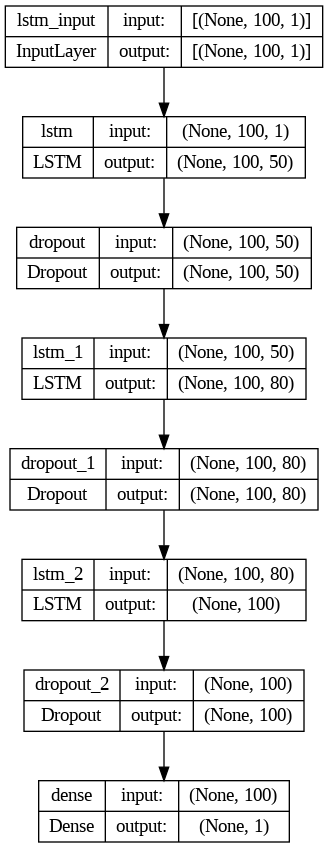

In [9]:
from keras.utils import plot_model
plot_model(lstm_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

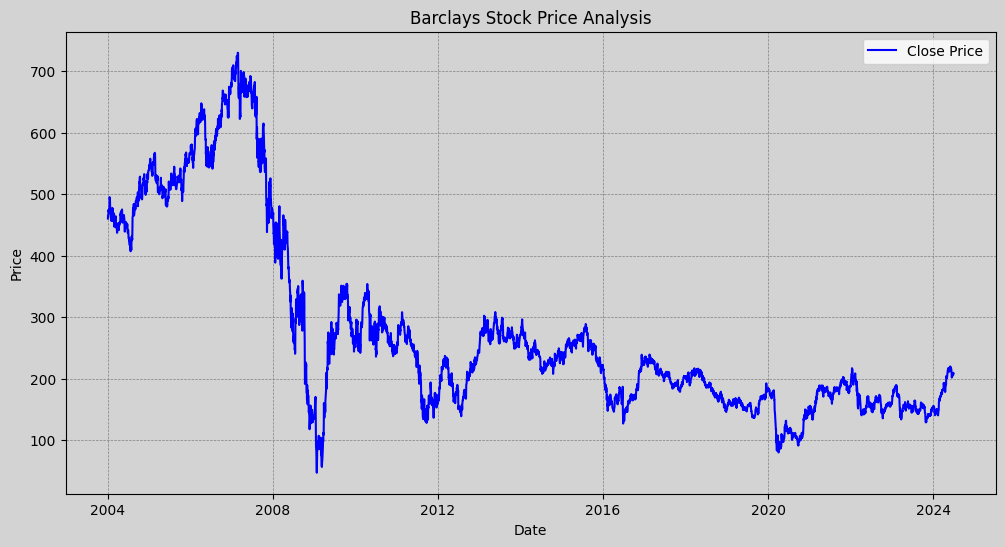

In [10]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Plotting the closing price
plt.plot(data["Date"], data["Close"], label='Close Price', color='blue')
plt.title("Barclays Stock Price Analysis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gca().set_facecolor('lightgray')  # Plot background
plt.gcf().set_facecolor('lightgray')  # Figure background
plt.legend()
plt.show()

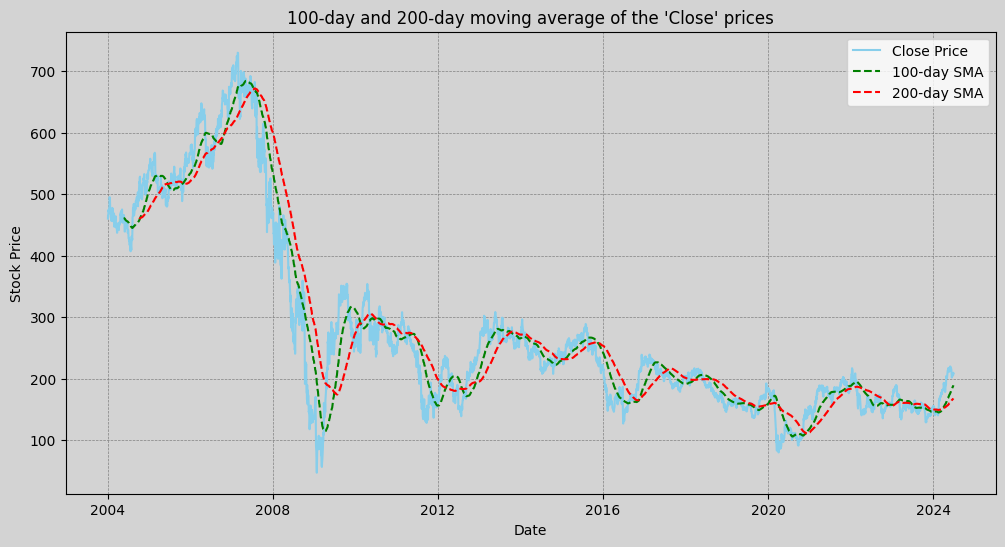

In [11]:
#Calculating and plotting the 100-day and 200-day moving average of the 'Close' prices
data['SMA_100'] = data['Close'].rolling(window=100).mean()  # 100-day Simple Moving Average
data['SMA_200'] = data['Close'].rolling(window=200).mean()  # 200-day Simple Moving Average

plt.figure(figsize=(12,6))
plt.plot(data["Date"], data["Close"], label='Close Price',  color='skyblue')
plt.plot(data["Date"], data['SMA_100'], label='100-day SMA',linestyle='--', color='g')
plt.plot(data["Date"], data['SMA_200'], label='200-day SMA',linestyle='--', color='r')
plt.title("100-day and 200-day moving average of the 'Close' prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gca().set_facecolor('lightgray')
plt.gcf().set_facecolor('lightgray')
plt.legend()
plt.show()

In [12]:
#Extracting the Last 100 Days of Training Data
pas_100_days = data_train.tail(100)

#Combining with Test Data
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)

#Scaling the Test Data
data_test_scale  =  scaler.fit_transform(data_test)

#Initializing Lists and Generating Sequences from Scaled Test Data
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

33/33 [==============================] - 2s 55ms/step
Root Mean Squared Error: 11.077363405110368


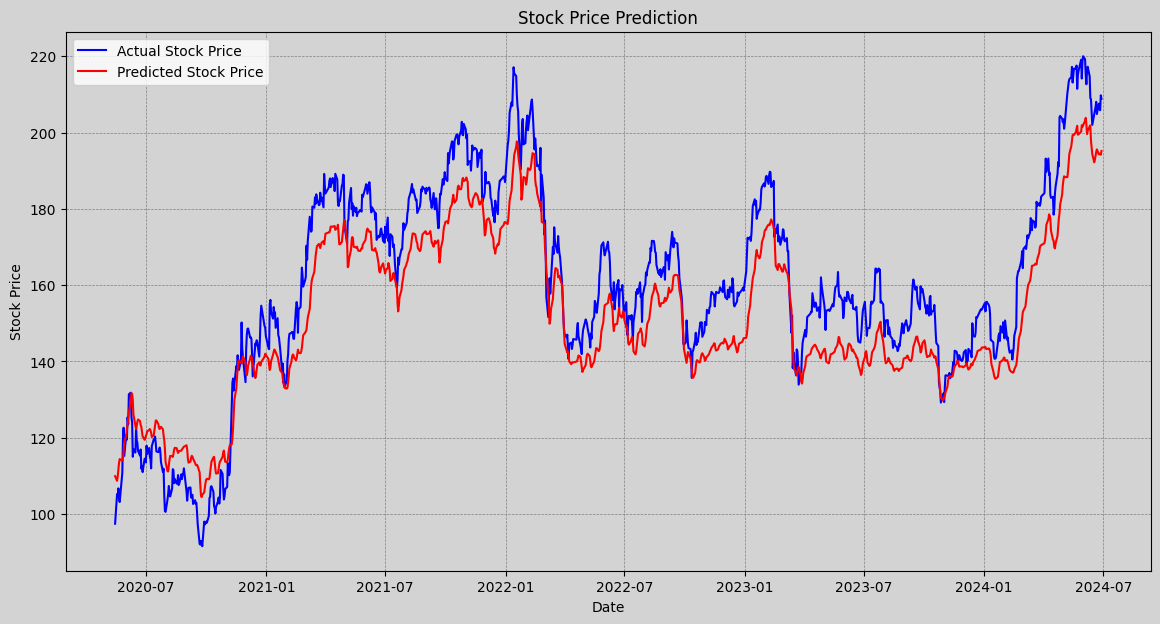

1/1 [==============================] - 0s 56ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


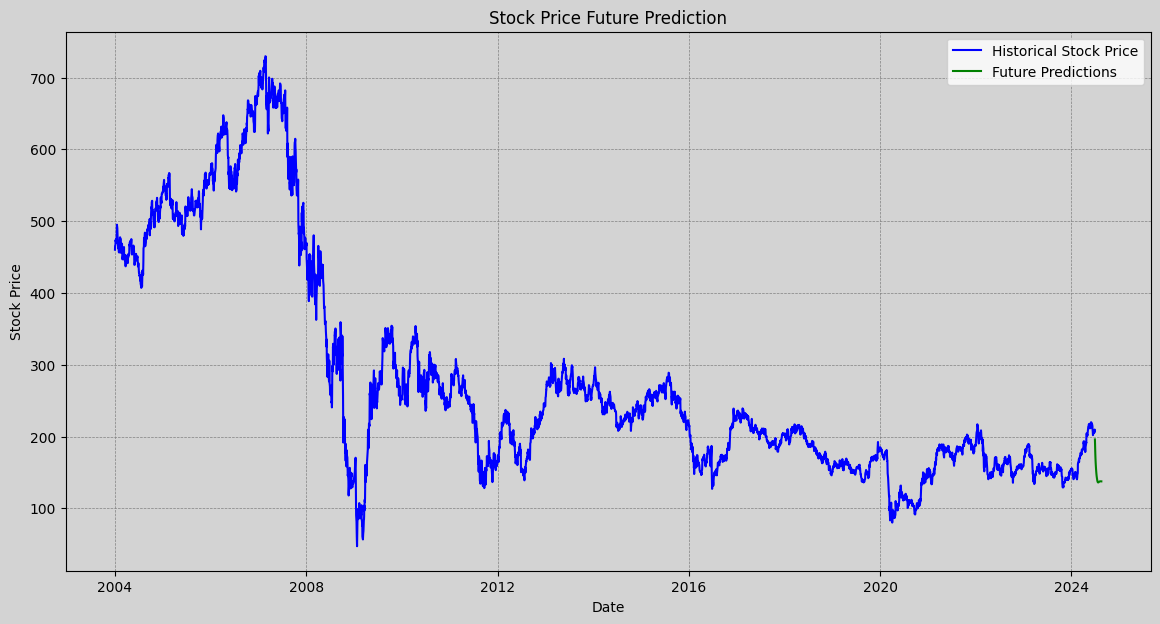

In [13]:
# Predicting on the Test Data
predictions = lstm_model.predict(x)

# Inverse Transforming the Predictions and Actual Values to Original Scale
predictions = scaler.inverse_transform(predictions)
y_actual = scaler.inverse_transform(y.reshape(-1, 1))

# Calculating the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_actual, predictions))
print(f'Root Mean Squared Error: {rmse}')

# Plotting the Predictions and Actual Values
plt.figure(figsize=(14,7))
plt.plot(data['Date'][len(data_train):len(data_train) + len(y_actual)], y_actual, color='blue', label='Actual Stock Price')
plt.plot(data['Date'][len(data_train):len(data_train) + len(predictions)], predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gca().set_facecolor('lightgray')
plt.gcf().set_facecolor('lightgray')
plt.show()

# Future Prediction Code
# Ensure correct scaling and transformation of the last 100 days
last_100_days = data['Close'].values[-100:].reshape(-1, 1)
last_100_days_scaled = scaler.transform(last_100_days)

# Ensure correct shape of the input data
current_input = last_100_days_scaled.reshape(1, last_100_days_scaled.shape[0], last_100_days_scaled.shape[1])

# Number of future days to predict
future_days = 50

# Generating future predictions
future_predictions = []

for _ in range(future_days):
    future_pred = lstm_model.predict(current_input)
    future_predictions.append(future_pred[0, 0])
    current_input = np.append(current_input[:, 1:, :], future_pred.reshape(1, 1, 1), axis=1)

# Inverse transform the future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(last_date + timedelta(1), periods=future_days).tolist()

# Plotting the future predictions
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], color='blue', label='Historical Stock Price')
plt.plot(future_dates, future_predictions, color='green', label='Future Predictions')
plt.title('Stock Price Future Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gca().set_facecolor('lightgray')
plt.gcf().set_facecolor('lightgray')
plt.show()



In [21]:
# Install Prophet
!pip install prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgivck1bc/sjojbwhw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgivck1bc/uzwe9sjo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65686', 'data', 'file=/tmp/tmpgivck1bc/sjojbwhw.json', 'init=/tmp/tmpgivck1bc/uzwe9sjo.json', 'output', 'file=/tmp/tmpgivck1bc/prophet_model1_cxd8gz/prophet_model-20240716153104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:31:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:31:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


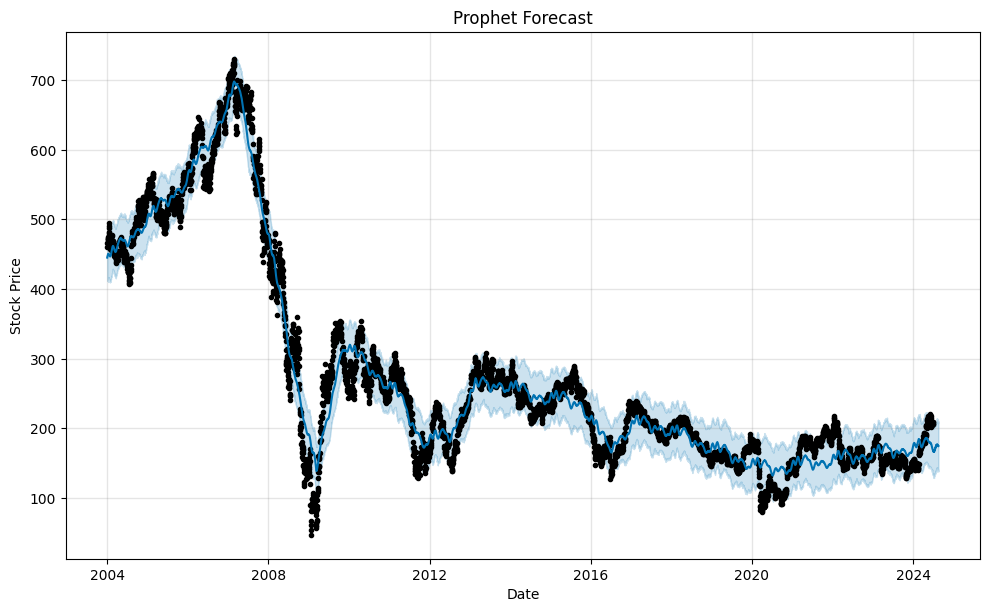

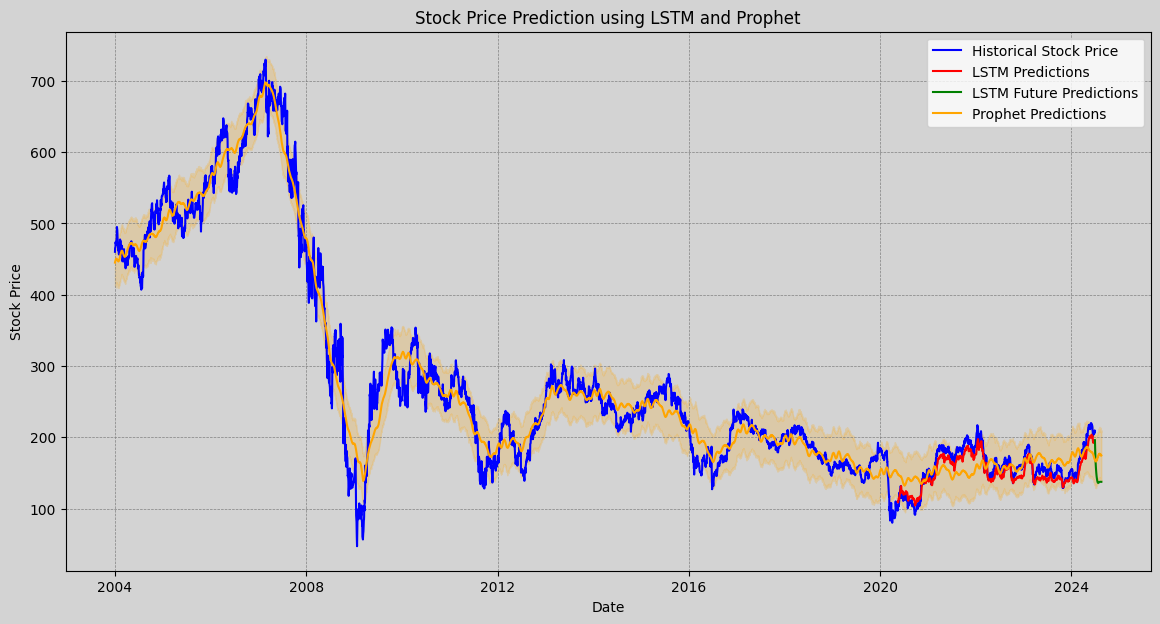

In [23]:
from prophet import Prophet

# Prepare the data for Prophet
prophet_data = data[['Date', 'Close']]
prophet_data.columns = ['ds', 'y']

# Initialize and fit the Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data)

# Make future predictions
future = prophet_model.make_future_dataframe(periods=future_days)
forecast = prophet_model.predict(future)

# Plot the forecast
fig = prophet_model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# Combine LSTM and Prophet predictions
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], color='blue', label='Historical Stock Price')
plt.plot(data['Date'][len(data_train):len(data_train) + len(predictions)], predictions, color='red', label='LSTM Predictions')
plt.plot(future_dates, future_predictions, color='green', label='LSTM Future Predictions')
plt.plot(forecast['ds'], forecast['yhat'], color='orange', label='Prophet Predictions')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)
plt.title('Stock Price Prediction using LSTM and Prophet')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gca().set_facecolor('lightgray')
plt.gcf().set_facecolor('lightgray')
plt.show()